In [1]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

# Step 1
# download data to Colab
#for ens in np.arange(1,11):
#    os.system('wget -O HW5_ens'+str(ens).zfill(2)+'.nc https://zenodo.org/record/7384713/files/HW5_ens'+str(ens).zfill(2)+'.nc?download=1')


In [2]:
#!pip install netCDF4

In [3]:
# the nc file has 4 dimensions: initial time (time), lead time (step), latitude, longitude
# ens01 indicates the first ensemble member and ens02 is the second ensemble member
import netCDF4


In [4]:
nEnsem = 10
nInit = 8
nLead = 47
nLat = 121
nLon = 240
gh = np.zeros((nEnsem, nInit, nLead, nLat, nLon)) # number of ensemble, initialization time, forecast lead, lat, lon
for i in range(1,nEnsem+1):
    fp     = './HW5_ens'+str(i).zfill(2)+'.nc'
    nc     = netCDF4.Dataset(fp)
    gh[i-1,] = nc['gh'][:]
y = nc['latitude'][:]
x = nc['longitude'][:]
lon,lat = np.meshgrid(x,y)

In [5]:
gh_weighted = gh * np.cos(lat/180*np.pi)**0.5
#gh_weighted[0, 0, 0, -1, :] = 0
#gh_weighted[0, 0, 0, 0, :] = 0
gh_weighted = np.reshape(gh_weighted,[int(np.size(gh_weighted)/(np.size(y)*np.size(x))),int(np.size(y)*np.size(x))])



In [11]:
import numpy as np
from sklearn.decomposition import PCA
modes = 100
pca = PCA(n_components=modes)
pca.fit(gh_weighted)

PCA(n_components=100)

In [12]:
# Step 2
# dimension reduction
# derive EOF pattern (spatial structure) and principal components (time series)
EOF     = np.reshape(pca.components_,[modes,np.size(y),np.size(x)])
pcs     = np.dot(gh_weighted,pca.components_.transpose())
pcs_std = np.reshape(np.std(pcs,axis=0),[100,1])
pcs     = pcs/np.std(pcs_std,axis=0)
pcs     = np.reshape(pcs,[nEnsem, nInit, nLead, modes])
print(EOF.shape, pcs.shape)


(100, 121, 240) (10, 8, 47, 100)


In [13]:
# Step 3
# calculate deviation from ensemble mean
gh_prime  = pcs - pcs.mean(axis=0)
print(gh_prime.shape)

(10, 8, 47, 100)


In [46]:
modes=100
climVariance = np.zeros(shape=(modes, modes))
var_x1_sum = np.zeros(shape=(modes, modes))
count = 0
for caseIdx in range(nInit):
    for tIdx in range(30, nLead):
        x = np.reshape(gh_prime[:, caseIdx, tIdx, :], [nEnsem, modes])
        sigma_climate = np.dot(x.transpose(), x)
        climVariance = (climVariance*count + sigma_climate) / (count + 1)
        
        x1 = np.reshape(gh_prime[:, caseIdx, tIdx, :], [10, modes])
        sigma_clim = x1.transpose().dot(x1)
        var_x1_sum = (var_x1_sum * count + sigma_clim) / (count + 1)

        count += 1

variation = np.zeros(shape=(modes, modes))
count = 0
for caseIdx in range(nInit):
    for tIdx in range(0, nLead):
        x = np.reshape(gh_prime[:, caseIdx, tIdx, :], [nEnsem, modes])
        sigma = np.dot(x.transpose(), x)
        variation -= sigma
        count += 1
variation /= count
variation = climVariance + variation

print(climVariance.shape, variation.shape)

(100, 100) (100, 100)


In [47]:
# Eigen value & vector of normalized variation
eigVal, eigVec = np.linalg.eig(np.dot(variation, np.linalg.inv(climVariance)))
idx = eigVal.argsort()[::-1] # large to small eigenValue's index
eigVal = eigVal[idx]
eigVec = eigVec[:, idx] # (modes x modes)

pcs_tau = np.dot(np.reshape(gh_prime, [nEnsem * nInit, nLead, modes]), eigVec)
pcs_tau = np.reshape(pcs_tau, [nEnsem, nInit, nLead, modes])
print(pcs_tau.shape)

(10, 8, 47, 100)


388.10747117528365
310.1342332937604


(0.0, 46.0)

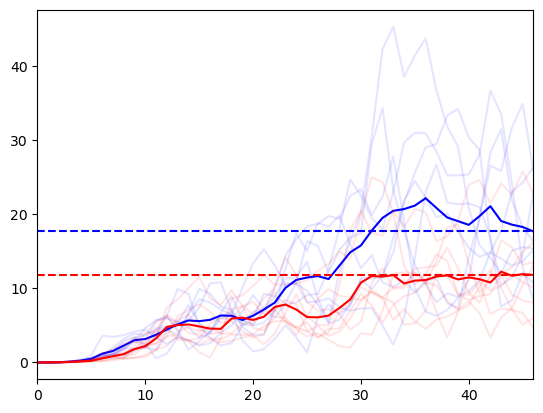

In [54]:
bmode = 0
memVariation = np.var(pcs_tau, axis=0)[:, :, mode].transpose()
lastTimeVarAverage = np.mean(np.var(pcs_tau, axis=0)[:, -1, mode], axis=0)
# assume last time step reaches climatology (sigma^2_inf)

# first mode
plt.figure()
plt.plot(memVariation, "b", alpha=0.1)
plt.plot(np.mean(memVariation, axis=1), "b")
plt.hlines(lastTimeVarAverage, xmin=0, xmax=nLead, color='blue', linestyle="--")

print(np.sum((pcs_tau.var(axis=0))[:, -1, mode].mean(axis=0) - (pcs_tau.var(axis=0)[0, :, mode])))

mode = 3
memVariation = np.var(pcs_tau, axis=0)[:, :, mode].transpose()
lastTimeVarAverage = np.mean(np.var(pcs_tau, axis=0)[:, -1, mode], axis=0)
# assume last time step reaches climatology (sigma^2_inf)

print(np.sum((pcs_tau.var(axis=0))[:, -1, mode].mean(axis=0) - (pcs_tau.var(axis=0)[0, :, mode])))

# 3rd mode
plt.plot(memVariation, "r", alpha=0.1)
plt.plot(np.mean(memVariation, axis=1), "r")
plt.hlines(lastTimeVarAverage, xmin=0, xmax=nLead, color='red', linestyle="--")

plt.xlim(0, nLead-1)



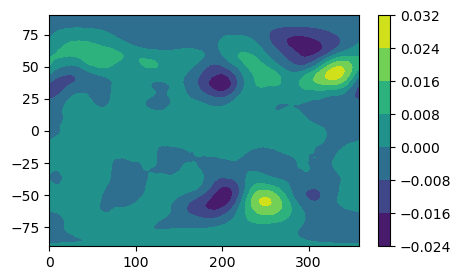

In [65]:
pc = np.dot(eigVec[:, 0].transpose(), pca.components_)
pc = np.reshape(pc, (nLat, nLon))
plt.figure(figsize=(5, 3))
plt.contourf(lon, lat, pc)
plt.colorbar()

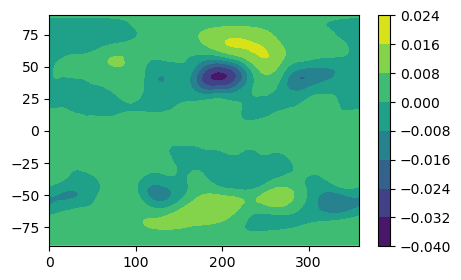

In [66]:
pc = np.dot(eigVec[:, 1].transpose(), pca.components_)
pc = np.reshape(pc, (nLat, nLon))
plt.figure(figsize=(5, 3))
plt.contourf(lon, lat, pc)
plt.colorbar()

In [67]:
# last point